In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import itertools
import random
from matplotlib import pyplot as plt
from pair_trading_foundations.data_generation import ExecutePairTrading, \
generate_training_data, calculate_beta_p1, calculate_beta_p2
from pair_trading_foundations.utils import GetSP500Data
import statsmodels.api as sm
from importlib import reload

random.seed(23)
import cProfile
import pstats
import pickle
import plotly.express as px
from time import time
import warnings
warnings.filterwarnings('ignore')

import os
if not os.path.exists('Generated'):
    os.makedirs('Generated')

def chunker(seq, size):
    # split a list into chunks
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# Extract data from API

In [2]:
# data = GetSP500Data('1999-12-01', '2024-03-01').get_all_sp_tickers().get_consolidated_data()
# spy_df = GetSP500Data('1999-12-01', '2024-03-01').get_single_stock_history('SPY')
# spy_df.to_csv('../../Data/1999-12-01-2024-03-01_SPY.csv', index=False)

In [6]:
data = pd.read_csv('../../Data/sp500_full_19991201_to_20240301.csv')
spy_df = pd.read_csv('../../Data/1999-12-01-2024-03-01_SPY.csv')
spy_df['Close_SPY'] = spy_df['Adj Close']

In [7]:
# # data = pd.read_csv('../sp500_full_20181231_to_20231229.csv')
# value_count_tb = data[['Ticker']].groupby('Ticker').size().reset_index()
# value_count_tb.columns = ['Ticker', 'Count']
# # stock_to_keep = value_count_tb['Ticker'][value_count_tb.Count==value_count_tb.Count.max()]
# data = data[data.Ticker.isin(stock_to_keep)]

In [8]:
# value_count_tb

# Generate for all pairs

In [12]:
"""
Uncomment the chunk below to get pairs for random combinations
"""
# tickers = list(set(data.Ticker.values))
# combinations = list(itertools.combinations(tickers, 2))
# len(combinations)
# batches = list(chunker(combinations, 1000))

"""
Uncomment the chunk below to get pairs from clustering (Option1)
"""
# Load pairs found from Clustering
clustering_pairs = pd.read_csv('../../Outputs/pairs_found_by_clustering.csv')

# # Make sure the stock has full history
# clustering_pairs = clustering_pairs[
#                     clustering_pairs.ticker1.isin(stock_to_keep) & 
#                     clustering_pairs.ticker2.isin(stock_to_keep)
#                     ].reset_index(drop=True)
combinations = [(clustering_pairs.ticker1[i], clustering_pairs.ticker2[i]) for i in range(clustering_pairs.shape[0])]
batches = list(chunker(combinations, 50))

In [27]:
len(batches[9])

50

In [14]:
# This code allows you to reimport the module if changes happen in data_generation.py
from importlib import reload
# import data_generation
# reload(data_generation)

i = 0
for batch in batches:
    start_ts=time()
    print(f'Getting {i+1}th out of {len(batches)} batches')
    max_pairs = -1
    features_tb, labels_tb = generate_training_data(
        data=data,
        sp500_df=spy_df,
        moving_average=60,
        training_len=300,
        test_len=60,
        entry_signal=1.5,
        exit_signal=0.5,
        calculate_label=True,
        verbose=False,
        max_combinations=max_pairs,
        combinations=batch
    )
    combined = pd.merge(features_tb, labels_tb, how='left', on=['Date', 'Ticker_P1','Ticker_P2']).reset_index(drop=True)
    combined = combined[combined.pnls.notnull()].reset_index(drop=True)
    combined.to_csv(f'../../Data/Generated/pair_features_cluster_pair_{i+1}th_batch_300_60.csv', index=False)
    end_ts = time()
    print(f"Took {end_ts - start_ts} seconds")
    i+=1
combined

Getting 1th out of 10 batches
50 stock pairs detected
Took 0.3900890350341797 to initilize. Entering ticker pair loop
Max combination = 50
Took 230.2263581752777 to finish
Took 232.35794138908386 seconds
Getting 2th out of 10 batches
50 stock pairs detected
Took 0.7452609539031982 to initilize. Entering ticker pair loop
Max combination = 50
Took 228.06274795532227 to finish
Took 230.17154622077942 seconds
Getting 3th out of 10 batches
50 stock pairs detected
Took 0.36968088150024414 to initilize. Entering ticker pair loop
Max combination = 50
Took 218.01577591896057 to finish
Took 219.99162030220032 seconds
Getting 4th out of 10 batches
50 stock pairs detected
Took 0.370913028717041 to initilize. Entering ticker pair loop
Max combination = 50
Took 255.87986493110657 to finish
Took 258.2466690540314 seconds
Getting 5th out of 10 batches
50 stock pairs detected
Took 0.36548495292663574 to initilize. Entering ticker pair loop
Max combination = 50
Took 254.48475909233093 to finish
Took 256

,Ticker_P1,Date,High_P1,Low_P1,Volume_P1,Close_P1,Ticker_P2,High_P2,Low_P2,Volume_P2,...,abs_spread,abs_spread_mean,abs_spread_std,abs_spread_mean_MA,abs_spread_std_MA,beta_P1,beta_P2,pnls,actual_abs_spread,actual_abs_spread_std
0,EBAY,2001-02-09,4.958439,4.491530,30952627.0,4.295955,WAT,72.900002,69.300003,439200.0,...,65.704045,51.185351,18.898375,68.287508,5.657686,0.044766,0.828783,0.0,48.169779,10.577070
1,EBAY,2001-02-12,5.096538,4.682239,28379894.0,4.549012,WAT,72.750000,70.000000,435500.0,...,66.900985,51.357491,18.805003,68.390603,5.573091,0.044782,0.830578,0.0,47.834381,10.293037
2,EBAY,2001-02-13,5.326705,4.984743,46216051.0,4.573112,WAT,74.599998,70.849998,635900.0,...,66.726891,51.530356,18.706548,68.409659,5.565280,0.044846,0.831580,0.0,47.492506,9.996234
3,EBAY,2001-02-14,5.366162,5.017624,51551597.0,4.838222,WAT,71.199997,68.110001,694900.0,...,66.031781,51.699271,18.607346,68.444702,5.543165,0.045006,0.832657,0.0,47.169752,9.700695
4,EBAY,2001-02-15,5.583176,5.287247,40134442.0,4.868347,WAT,72.699997,71.000000,353700.0,...,67.081650,51.872414,18.507410,68.482521,5.525677,0.045152,0.833541,0.0,46.807518,9.349842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223816,COF,2023-11-27,106.610001,105.430000,1556800.0,105.709412,EOG,123.269997,121.750000,2384200.0,...,14.781067,19.005903,10.366659,25.730630,7.696757,0.228406,0.287620,0.0,14.399425,7.017433
223817,COF,2023-11-28,109.050003,106.139999,1874500.0,108.098778,EOG,124.519997,122.690002,3380900.0,...,13.018646,19.006770,10.366146,25.529821,7.869593,0.228585,0.287301,0.0,14.556447,7.089813
223818,COF,2023-11-29,111.559998,109.180000,2087500.0,109.641907,EOG,124.389999,122.699997,3000100.0,...,11.083679,19.000086,10.370620,25.228623,8.071713,0.228880,0.286856,0.0,14.753053,7.154054
223819,COF,2023-11-30,111.970001,110.180000,2439300.0,111.165131,EOG,125.970001,121.860001,5597800.0,...,9.393921,18.986012,10.380811,24.899024,8.308344,0.229204,0.286360,0.0,14.987321,7.204690


In [ ]:
combined = pd.DataFrame()
for i in range(10):
    batch_tb = pd.read_csv(f'../../Data/Generated/pair_features_cluster_pair_{i+1}th_batch_300_60.csv')
    combined = pd.concat([combined, batch_tb])
combined.reset_index(drop=True,inplace=True)

count    223821.000000
mean          0.000464
std           0.012619
min          -0.495111
25%          -0.000156
50%           0.000000
75%           0.003968
max           0.202199
Name: pnls, dtype: float64

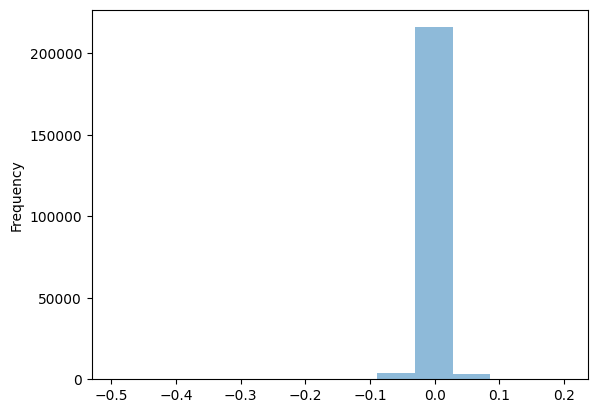

In [34]:
combined = labels_tb.dropna()
combined.pnls.plot.hist(bins=12, alpha=0.5)
combined.pnls.describe()

In [39]:
combined.to_csv('../../Data/Generated/pair_features_cluster_pair_all_batch_300_60.csv', index=False)

# Playground

In [ ]:
features_tb, labels_tb = generate_training_data(
        data=data,
        sp500_df=spy_df,
        moving_average=60,
        training_len=300,
        test_len=60,
        entry_signal=1.5,
        exit_signal=0.5,
        calculate_label=True,
        verbose=False,
        max_combinations=1,
        combinations=batches[0]
    )
combined = pd.merge(features_tb, labels_tb, how='left', on=['Date', 'Ticker_P1','Ticker_P2']).reset_index(drop=True)
combined = combined[combined.pnls.notnull()].reset_index(drop=True)

In [ ]:
combined.beta_P2.describe()